## Analyze A/B Test Results


## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

**As you work through this notebook, follow along in the classroom and answer the corresponding quiz questions associated with each question.** The labels for each classroom concept are provided for each question.  This will assure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the criteria.  As a final check, assure you meet all the criteria on the [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [8]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [9]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the cell below to find the number of rows in the dataset.

In [10]:
df.shape[0]

294478

c. The number of unique users in the dataset.

In [11]:
df['user_id'].nunique()

290584

d. The proportion of users converted.

In [12]:
df['converted'].mean()

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't match.

In [13]:
print(df.query('group == "treatment" & landing_page != "new_page"').shape[0])
print(df.query('group != "treatment" & landing_page == "new_page"').shape[0])

1965
1928


f. Do any of the rows have missing values?

In [14]:
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to figure out how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [15]:
df2 = df[((df['group'] == 'treatment') == (df['landing_page'] == 'new_page')) == True]
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [16]:
df2.shape[0]

290585

In [17]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [18]:
df2['user_id'].nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [19]:
df2[df2['user_id'].duplicated()]['user_id']

2893    773192
Name: user_id, dtype: int64

c. What is the row information for the repeat **user_id**? 

In [20]:
df2[df2['user_id'] == 773192]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [21]:
df2 = df2[~df2['user_id'].duplicated()]
df2.shape[0]

290584

`4.` Use **df2** in the cells below to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [22]:
df2[df2['converted'] == 1].shape[0] / df2.shape[0]

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [23]:
df2.query('converted == 1 and group == "control"').shape[0] / df2.query('group == "control"').shape[0]

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [24]:
df2.query('converted == 1 and group == "treatment"').shape[0] / df2.query('group == "treatment"').shape[0]

0.11880806551510564

d. What is the probability that an individual received the new page?

In [25]:
df2[df2['landing_page'] == 'new_page'].shape[0] / df2.shape[0]

0.5000619442226688

e. Consider your results from parts (a) through (d) above, and explain below whether you think there is sufficient evidence to conclude that the new treatment page leads to more conversions.

**The overall conversion rate is 0.11959708724499628**
<br>
**Conversion rate for control page is 0.1203863045004612**
<br>
**Conversion rate for treatment page is 0.11880806551510564**
<br>
**There is a very small difference between treatment and control pages conversion rates, thus there might be an affect for the new page on conversion rate or there might not be, in order to find out the answer we have to make an A/B Test.**

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

**$H_0$** : **$p_{new} - p_{old} \leq$ 0**
<br>
**$H_1$** : **$p_{new} - p_{old} > 0$**

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **conversion rate** for $p_{new}$ under the null? 

In [26]:
p_new = df['converted'].mean()
p_new

0.11965919355605512

b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [27]:
p_old = df['converted'].mean()
p_old

0.11965919355605512

c. What is $n_{new}$, the number of individuals in the treatment group?

In [28]:
n_new_df = df2[df2['group'] == 'treatment']
n_new = n_new_df.shape[0]
n_new

145310

d. What is $n_{old}$, the number of individuals in the control group?

In [29]:
n_old_df = df2[df2['group'] == 'control']
n_old = n_old_df.shape[0]
n_old

145274

e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [65]:
new_page_converted = np.random.binomial(1, p_new, n_new)
new_page_converted

array([0, 0, 0, ..., 1, 1, 0])

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [66]:
old_page_converted = np.random.binomial(1, p_old, n_old)
old_page_converted

array([0, 0, 0, ..., 0, 0, 0])

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [67]:
diff = new_page_converted.mean() - old_page_converted.mean()
diff

0.0011262571642827596

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [33]:
p_diffs = []
for i in range(10000):
    new = np.random.binomial(1, p_new, n_new)
    old = np.random.binomial(1, p_old, n_old)
    new_mean = new.mean()
    old_mean = old.mean()
    p_diffs.append(new_mean - old_mean)

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

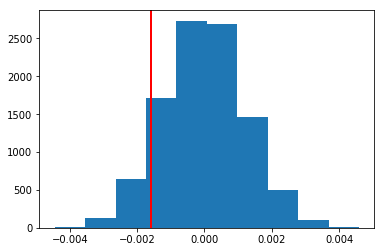

In [34]:
obs_diff = n_new_df['converted'].mean() - n_old_df['converted'].mean()

plt.hist(p_diffs);
plt.axvline(x=obs_diff, color='r', linewidth=2);

**As the difference between treatment and control pages conversion rates was very small the shape was expected the shape of ouru simulated data to be normal distributed around mean 0 (our null hypothesis) and the shape we figured out from part i is normal distribution with mean around 0 as expected**

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [35]:
p_val = (p_diffs > obs_diff).mean()
p_val

0.90039999999999998

k. Please explain using the vocabulary you've learned in this course what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**The result we collected from part j is called the "p-value" which is the probability of observing your statistic (or one more extreme in favor of the alternative) if the null hypothesis is true.**
<br>
**When p-value is smaller than Type I error rate then we have strong evidence to "Reject The Null".**
<br>
**When p-value is greater than Type I error rate then we Fail to Reject The Null".**
<br>
**In our case p-value = 0.9004 which is greater than 0.05 (Type 1 Error Rate) the decision is "Fail to Reject The Null" which means that the new page has a lower or equal conversion rate than the old page so no need to change to the new one.**

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [68]:
import statsmodels.api as sm

convert_old = df2.query('group == "control" and converted == 1').shape[0]
convert_new = df2.query('group == "treatment" and converted == 1').shape[0]
n_old = df2[df2['group'] == 'control'].shape[0]
n_new = df2[df2['group'] == 'treatment'].shape[0]

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](https://docs.w3cub.com/statsmodels/generated/statsmodels.stats.proportion.proportions_ztest/) is a helpful link on using the built in.

In [69]:
sm_zp_val = sm.stats.proportions_ztest([convert_old,convert_new], [n_old,n_new], alternative='smaller')
sm_zp_val

(1.3109241984234394, 0.90505831275902449)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**Z score is a measure of how many standard deviations below or above the population mean a raw score is according to [statisticshowto](https://www.statisticshowto.datasciencecentral.com/probability-and-statistics/z-score/) website.** 
<br>
**According to [esri.com](http://resources.esri.com/help/9.3/arcgisdesktop/com/gp_toolref/spatial_statistics_toolbox/what_is_a_z_score_what_is_a_p_value.htm) "If your Z score is between -1.96 and +1.96, your p-value will be larger than 0.05, and you cannot reject your null hypothesis."**
<br>
**In other words for a normal distribution dataset the 95% of the data lays between -1.96 and 1.96 standard deviation and in our case the Type I error rate is 5% which is the rest of 95% and our Z score happened to be inside that range (-1.96<1.311<1.96) and because of that we expect high p-value and we have no evidence to reject the null.**
<br>
**Thus -1.96 < Z score = 1.31 < 1.96 and p-value = 0.9051 > 0.05 obtained from part m agree the findings in part j which is p-value = 0.9004**

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**For any regression model we want to create if it has only two categorical dependent variables as in our case (conversion or no conversion) we choose Logistic Regression**

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, you first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [38]:
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [39]:
df2['intercept'] = 1
df2[['not_ab_page','ab_page']] = pd.get_dummies(df2['group'])
df2 = df2.drop(['not_ab_page'], axis=1)
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


c. Use **statsmodels** to instantiate your regression model on the two columns you created in part b., then fit the model using the two columns you created in part **b.** to predict whether or not an individual converts. 

In [40]:
logit_mod = sm.Logit(df2['converted'], df2[['ab_page','intercept']])
results = logit_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Tue, 14 Jan 2020   Pseudo R-squ.:               8.077e-06
Time:                        14:40:03   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
==============================================================================
"""

d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [70]:
1 / np.exp(results.params)

ab_page      1.015102
intercept    7.306593
dtype: float64

**In the last created regression model we obtained that for each 1 unit decrease in ab_page, conversion is 1.015 times as likely holding all else constant which is not very large value to change from the old page to the new one.**

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in **Part II**?

**p-value = 0.19**
<br>
**In Part II the p-value is for 'One Tailed Test' which cares about only $P_{new}$ greater than $P_{old}$ which is the Alternative Hypothesis while in Part III the Logistic Regression test was 'Two Tailed Test' which is interested in individual values $P_{new}$ or $P_{old}$ separetly**
<br>
**Also according to [graphpad.com](https://www.graphpad.com/guides/prism/7/statistics/one-tail_vs__two-tail_p_values.htm?toc=0&printWindow) we can relate the p value from Part III to Part II as following (1 - (0.19/2) = 0.95) and this value is something near 0.905 that was obtained from Part III.**

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**`.`** **Fitting more factors to the model will always be better because the model will be studied in multiple point of views.**
<br>
**`.`** **Also with limited factors in the model might give uncertain results as [Simpson's Paradox](https://en.wikipedia.org/wiki/Simpson%27s_paradox) phenomenon explains: "Simpson's paradox is a phenomenon in probability and statistics, in which a trend appears in several different groups of data but disappears or reverses when these groups are combined."**
<br>
**`.`** **But fitting too many factors may lead to disadvantages like forcing the machine to look into patterns that does not really exist to make a decision in Machine Learning Technique.**
<br>
**`.`** **Also acording to [Wikipedia](https://en.wikipedia.org/wiki/Multiple_comparisons_problem) "In statistics, the multiple comparisons, multiplicity or multiple testing problem occurs when one considers a set of statistical inferences simultaneously[1] or infers a subset of parameters selected based on the observed values.[2] In certain fields it is known as the look-elsewhere effect."**

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. You will need to read in the **countries.csv** dataset and merge together your datasets on the appropriate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [42]:
df2.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
intercept       0
ab_page         0
dtype: int64

In [43]:
df_cont = pd.read_csv('countries.csv')
df_cont.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [44]:
df3 = df2.join(df_cont['country'])

In [45]:
df3.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,UK
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,UK
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,UK
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,UK


In [46]:
df3.isnull().sum()

user_id            0
timestamp          0
group              0
landing_page       0
converted          0
intercept          0
ab_page            0
country         3842
dtype: int64

In [47]:
df3 = df3[~df3['country'].isnull()]
df3.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
intercept       0
ab_page         0
country         0
dtype: int64

In [48]:
df3[['ca','uk','us']] = pd.get_dummies(df3['country'])

In [49]:
df3 = df3.drop('intercept', axis=1)
df3 = df3.drop('ca', axis=1)
df3.head()

,user_id,timestamp,group,landing_page,converted,ab_page,country,uk,us
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,0,UK,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,0,US,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,UK,1,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,UK,1,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,0,UK,1,0


In [50]:
df3.corr()

,user_id,converted,ab_page,uk,us
user_id,1.000000,0.001571,-0.001989,-0.000562,-0.000677
converted,0.001571,1.000000,-0.002574,0.001126,-0.000141
ab_page,-0.001989,-0.002574,1.000000,-0.003515,0.002933
uk,-0.000562,0.001126,-0.003515,1.000000,-0.881917
us,-0.000677,-0.000141,0.002933,-0.881917,1.000000


**The above results show that there is no significant relation between conversion and country as the correlation factors between both countrie and converted column also between both countries and ab_page column are very small and goes to zero which is not practically significant.**

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [51]:
df3['intercept'] = 1

In [52]:
logit_mod1 = sm.Logit(df3['converted'], df3[['ab_page','uk','us','intercept']])
results1 = logit_mod1.fit()
results1.summary()

Optimization terminated successfully.
         Current function value: 0.366154
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               286742
Model:                          Logit   Df Residuals:                   286738
Method:                           MLE   Df Model:                            3
Date:                Tue, 14 Jan 2020   Pseudo R-squ.:               1.523e-05
Time:                        14:40:04   Log-Likelihood:            -1.0499e+05
converged:                       True   LL-Null:                   -1.0499e+05
                                        LLR p-value:                    0.3620
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ab_page       -0.0158      0.012     -1.376      0.169      -0.038       0.007
uk             0.0323      0.028      1.134      0.257      -0.023       0.088
us             0.0260      0.027      0.968      0.333      -0.027       0.079
intercept     -2.0145      0.027    -75.614      0.000      -2.067      -1.962
==============================================================================
"""

In [53]:
1 / np.exp(results1.params)

ab_page      1.015960
uk           0.968249
us           0.974296
intercept    7.496867
dtype: float64

**For the UK users conversion rate is 0.968249 times, holding all else constant.**<br>
**For the US users conversion rate is 0.974296 times, holding all else constant.**<br>
**For each 1 unit decrease in new_page, conversion is 1.015960 times holding all else constant.**<br>
**Values for both countries are less than 1 which is in favor of the old page and not practically significant to choose the new page over the old one.**<br>
**The value for the new page has a very samll advantage over the old page only by small margin 1.01596 and not practically significant to consider shifting to the new page**

In [54]:
df3['us_ab_page'] = df3['us'] * df3['ab_page']
df3['uk_ab_page'] = df3['uk'] * df3['ab_page']

In [55]:
logit_mod2 = sm.Logit(df3['converted'], df3[['ab_page','uk_ab_page','us_ab_page','intercept']])
results2 = logit_mod2.fit()
results2.summary()

Optimization terminated successfully.
         Current function value: 0.366155
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               286742
Model:                          Logit   Df Residuals:                   286738
Method:                           MLE   Df Model:                            3
Date:                Tue, 14 Jan 2020   Pseudo R-squ.:               1.152e-05
Time:                        14:40:05   Log-Likelihood:            -1.0499e+05
converged:                       True   LL-Null:                   -1.0499e+05
                                        LLR p-value:                    0.4902
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ab_page       -0.0042      0.037     -0.113      0.910      -0.077       0.069
uk_ab_page    -0.0032      0.040     -0.081      0.935      -0.081       0.075
us_ab_page    -0.0155      0.038     -0.411      0.681      -0.089       0.058
intercept     -1.9882      0.008   -245.028      0.000      -2.004      -1.972
==============================================================================
"""

In [56]:
1 / np.exp(results2.params)

ab_page       1.004224
uk_ab_page    1.003249
us_ab_page    1.015583
intercept     7.302102
dtype: float64

**For the uk_ab_page users conversion rate is 1.003249 times, holding all else constant.**<br>
**For the us_ab_page users conversion rate is 1.015583 times, holding all else constant.**<br>
**For each 1 unit decrease in new_page, conversion is 1.004224 times holding all else constant.**<br>
**All these values are not practically significant to choose the new page over the old one**

In [57]:
df3 = df3.drop('intercept', axis=1)
df3.corr()

,user_id,converted,ab_page,uk,us,us_ab_page,uk_ab_page
user_id,1.000000,0.001571,-0.001989,-0.000562,-0.000677,-0.002619,-0.000304
converted,0.001571,1.000000,-0.002574,0.001126,-0.000141,-0.002797,0.000055
ab_page,-0.001989,-0.002574,1.000000,-0.003515,0.002933,0.735462,0.376090
uk,-0.000562,0.001126,-0.003515,1.000000,-0.881917,-0.423897,0.652536
us,-0.000677,-0.000141,0.002933,-0.881917,1.000000,0.480654,-0.575483
us_ab_page,-0.002619,-0.002797,0.735462,-0.423897,0.480654,1.000000,-0.276608
uk_ab_page,-0.000304,0.000055,0.376090,0.652536,-0.575483,-0.276608,1.000000


**In the both regression models created all p-values are greater than 0.05 which make us fail to reject the null but the above correlation table for the model with (interpret interactions) suggest that there is a strong relation between ab_page and us_ab_page which is the people in US who were visiting the new page and converted (value = 0.735) and suggests that if the data was investigated in terms of separated countries it may results in different findings espically for US.** 

<a id='conclusions'></a>
## Finishing Up

> Congratulations!  You have reached the end of the A/B Test Results project!  You should be very proud of all you have accomplished!

> **Tip**: Once you are satisfied with your work here, check over your report to make sure that it is satisfies all the areas of the rubric (found on the project submission page at the end of the lesson). You should also probably remove all of the "Tips" like this one so that the presentation is as polished as possible.


## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations!

In [71]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0